In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('complaints_processed.csv')
df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [3]:
# Renaming columns 
df = df.rename(columns={'narrative':'tweet' })

# Removing SNo column
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,product,tweet
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


In [4]:
# Removing NaNs
df = df.dropna(subset=['tweet'])
print('NaNs are removed from the dataframe. Number of NaNs can be confirmed to be {}. The size of dataframe has reduced to {}'.format(df['tweet'].isnull().sum(), df.shape))

NaNs are removed from the dataframe. Number of NaNs can be confirmed to be 0. The size of dataframe has reduced to (162411, 2)


In [5]:
# Converting sentences to string
df['tweet'] = df['tweet'].astype(str)

In [6]:
# Importing train test splilt library 
from sklearn.model_selection import train_test_split

# Train-Test Splitting
train_data, test_data = train_test_split(df, test_size = 0.20)

In [7]:
# Train and test data dimensions
train_data.shape, test_data.shape

((129928, 2), (32483, 2))

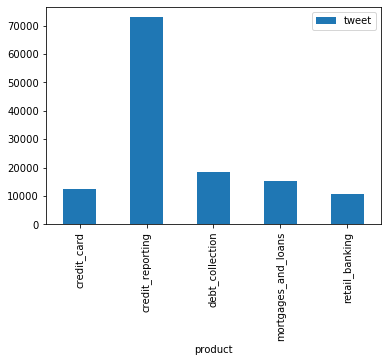

In [8]:
# Balance of train data
train_data.groupby('product').count().plot(kind='bar')
plt.show()

In [9]:
# Randomly selecting 7000 indices in classes with low value count
import numpy as np
to_add_1 = np.random.choice(train_data[train_data['product']=='credit_card'].index,size = 7000,replace=False)   
to_add_2 = np.random.choice(train_data[train_data['product']=='debt_collection'].index,size = 7000,replace=False) 
to_add_3 = np.random.choice(train_data[train_data['product']=='mortgages_and_loans'].index,size = 7000,replace=False)  
to_add_4 = np.random.choice(train_data[train_data['product']=='retail_banking'].index,size=7000,replace=False)

# Indices to be added
to_add = np.concatenate((to_add_1, to_add_2, to_add_3, to_add_4 ))
len(to_add)

28000

In [10]:
# Forming a dataframe for randomly selected indices
df_replicate = train_data[train_data.index.isin(to_add)]
df_replicate 

,product,tweet
45570,mortgages_and_loans,auto loan paid full auto loan company stopped ...
159573,credit_card,reported credit card id around via calling num...
9009,debt_collection,bank america attorney obtained wrongful judgem...
126151,credit_card,synchrony bank closed paypal credit card accou...
23014,mortgages_and_loans,trouble earlier time loosing job allowed make ...
...,...,...
98768,credit_card,hsbc credit card fraudulent transaction thus c...
107773,credit_card,received notification credit monitoring servic...
82720,credit_card,shocked reviewed credit report found day late ...
24649,mortgages_and_loans,hello would like file formal complaint celink ...


In [11]:
# Concatenating replicated df to orinigal df
train_data = pd.concat([train_data, df_replicate])
train_data['product'].value_counts()

credit_reporting       72934
debt_collection        25471
mortgages_and_loans    22323
credit_card            19399
retail_banking         17801
Name: product, dtype: int64

In [12]:
# Importing NLTK Libraries
import nltk
from nltk.corpus import stopwords
from nltk import *

# Declaring function for text preprocessing 

def preprocess_text(main_df):
  df_1 = main_df.copy()

  # remove stopwords
  nltk.download('stopwords')         # Downloading stopwords
  stop = stopwords.words('english')  
  df_1['tweet'] = df_1['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) 
  
  # remove punctuations and convert to lower case
  df_1['tweet'] = df_1['tweet'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
  
  # remove double spaces
  df_1['tweet'] = df_1['tweet'].apply(lambda x: re.sub(' ', ' ', x))

  return df_1  

In [13]:
# Preprocessing training and test data 
train_data = preprocess_text(train_data)
test_data = preprocess_text(test_data)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/andyzhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/andyzhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Verifying text preprocessing
train_data['tweet'].head()
# Declaring train labels
train_labels = train_data['product'] 
test_labels = test_data['product']


In [15]:
# Converting labels to numerical features
import numpy as np
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels = le.transform(train_labels)
test_labels = le.transform(test_labels)

print(le.classes_)
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

['credit_card' 'credit_reporting' 'debt_collection' 'mortgages_and_loans'
 'retail_banking']
(array([0, 1, 2, 3, 4]), array([19399, 72934, 25471, 22323, 17801]))
(array([0, 1, 2, 3, 4]), array([ 3167, 18238,  4677,  3667,  2734]))


In [16]:
import torch

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# One-hot encode the labels
num_classes = train_labels.max().item() + 1  # Assuming labels start from 0
train_labels_one_hot = torch.nn.functional.one_hot(train_labels, num_classes=num_classes)
test_labels_one_hot = torch.nn.functional.one_hot(test_labels, num_classes=num_classes)


In [17]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Parameters
max_words = 2500  # Maximum vocabulary size
max_sequence_length = 170
tokenizer = get_tokenizer("basic_english")  # Use a basic tokenizer

# Define a function to yield tokens
def yield_tokens(data_iter, tokenizer):
    for text in data_iter:
        yield tokenizer(text)

# Assuming train_data['tweet'] contains the text data
train_texts = train_data['tweet']  # Replace with your actual DataFrame column

# Build the vocabulary with a maximum size
vocab = build_vocab_from_iterator(
    yield_tokens(train_texts, tokenizer),
    max_tokens=max_words,
    specials=["<unk>"]
)
vocab.set_default_index(vocab["<unk>"])  # Handle unknown tokens

# Convert text to sequences
def text_to_sequence(texts, vocab, tokenizer):
    sequences = []
    for text in texts:
        tokens = tokenizer(text)
        sequences.append([vocab[token] for token in tokens])
    return sequences

# Generate sequences for train and test data
train_sequences = text_to_sequence(train_data['tweet'], vocab, tokenizer)  # Replace with your train text column
test_sequences = text_to_sequence(test_data['tweet'], vocab, tokenizer)    # Replace with your test text column


In [18]:
import torch
from torch.nn.utils.rnn import pad_sequence

# Convert sequences to PyTorch tensors and pad them
def pad_sequences(sequences, maxlen):
    sequences = [torch.tensor(seq[:maxlen]) for seq in sequences]  # Truncate to maxlen
    return pad_sequence(sequences, batch_first=True, padding_value=0)  # Pad with 0s

train_data = pad_sequences(train_sequences, maxlen=max_sequence_length)
test_data = pad_sequences(test_sequences, maxlen=max_sequence_length)

print(train_data.shape, test_data.shape)  # Check the shapes


torch.Size([157928, 170]) torch.Size([32483, 170])


In [19]:
embedding_dim = 32


In [20]:
import torch.nn as nn
import torch.nn.functional as F

# Model definition in PyTorch
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 128, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128 * 2, output_dim)  # Multiply by 2 for bidirectional LSTM

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])  # Use the last hidden state
        x = self.fc(x)
        return x


In [21]:
# Define model parameters
vocab_size = len(vocab)  # Assuming vocab is defined earlier
output_dim = num_classes  # Replace with the number of output classes

# Instantiate the PyTorch model
model = TextClassificationModel(vocab_size, embedding_dim, output_dim)
print(model)


TextClassificationModel(
  (embedding): Embedding(2500, 32)
  (lstm): LSTM(32, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define loss function (binary cross-entropy)
criterion = nn.BCEWithLogitsLoss()  # Use this for binary classification with logits

# Define optimizer (RMSprop)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

# Define metrics (accuracy)
def binary_accuracy(y_pred, y_true):
    y_pred = torch.round(torch.sigmoid(y_pred))  # Apply sigmoid and round predictions
    correct = (y_pred == y_true).float()  # Compare predictions with true labels
    return correct.sum() / len(correct)


In [23]:
import torch
import torch.nn as nn

# Check if GPU is available and define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class weights
class_weights = torch.tensor([4, 5, 3, 3, 4], dtype=torch.float).to(device)

# Update the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)



In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Device configuration for multi-GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model definition
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # Embed the input
        x = x.mean(dim=1)  # Pooling over sequence length (e.g., mean pooling)
        x = self.fc(x)  # Fully connected layer
        return x

# Replace with your actual parameters
vocab_size = 5000  # Example vocabulary size
embedding_dim = 128  # Chosen embedding dimension
output_dim = 5  # Number of output classes (e.g., categories of complaints)

# Initialize the model
model = TextClassificationModel(vocab_size, embedding_dim, output_dim)

# Validate embedding weights
model.embedding = model.embedding.to(torch.float).to(device)

# Wrap the model with DataParallel for multi-GPU training
model = nn.DataParallel(model)
model = model.to(device)

# Define class weights for weighted loss
class_weights = torch.tensor([4, 5, 3, 3, 4], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
batch_size = 48
epochs = 50

# Assuming `train_data`, `train_labels`, `test_data`, `test_labels` are already defined
train_data = train_data.long()  # Ensure data is in the correct dtype
train_labels = train_labels.long()  # Ensure labels are integers
test_data = test_data.long()  # Ensure data is in the correct dtype
test_labels = test_labels.long()  # Ensure labels are integers

# Ensure labels are within the valid range
assert train_labels.min() >= 0 and train_labels.max() < output_dim, "Train labels out of range!"
assert test_labels.min() >= 0 and test_labels.max() < output_dim, "Test labels out of range!"

# Create DataLoaders for train and validation datasets
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training and validation loop
for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, labels in train_loader:
        # Move inputs and labels to the correct device
        inputs, labels = inputs.to(device), labels.to(device)

        # Debugging: Ensure inputs and labels are correct
        assert inputs.dtype == torch.long, "Inputs to nn.Embedding must be of type torch.long."
        assert inputs.min() >= 0 and inputs.max() < vocab_size, f"Input values must be in range [0, {vocab_size - 1}]."

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_accuracy += torch.sum(preds == labels).item()

    # Print training statistics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = running_accuracy / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move inputs and labels to the correct device
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_accuracy += torch.sum(preds == labels).item()

    # Print validation statistics
    val_loss /= len(test_loader.dataset)
    val_accuracy /= len(test_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/50, Loss: 0.0150, Accuracy: 0.7045
Validation Loss: 0.0099, Validation Accuracy: 0.8185
Epoch 2/50, Loss: 0.0104, Accuracy: 0.8103
Validation Loss: 0.0094, Validation Accuracy: 0.8440
Epoch 3/50, Loss: 0.0096, Accuracy: 0.8269
Validation Loss: 0.0088, Validation Accuracy: 0.8447
Epoch 4/50, Loss: 0.0092, Accuracy: 0.8353
Validation Loss: 0.0087, Validation Accuracy: 0.8466
Epoch 5/50, Loss: 0.0089, Accuracy: 0.8401
Validation Loss: 0.0086, Validation Accuracy: 0.8502
Epoch 6/50, Loss: 0.0087, Accuracy: 0.8439
Validation Loss: 0.0086, Validation Accuracy: 0.8536
Epoch 7/50, Loss: 0.0086, Accuracy: 0.8475
Validation Loss: 0.0086, Validation Accuracy: 0.8491
Epoch 8/50, Loss: 0.0085, Accuracy: 0.8488
Validation Loss: 0.0090, Validation Accuracy: 0.8609
Epoch 9/50, Loss: 0.0084, Accuracy: 0.8503
Validation Loss: 0.0085, Validation Accuracy: 0.8464
Epoch 10/50, Loss: 0.0083, Accuracy: 0.8517
Validation Loss: 0.0088, Validation Accuracy: 0.8540
Epoch 11/50, Loss: 0.0083, Accuracy: 0.

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# LSTM-Based Text Classification Model
class LSTMTextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMTextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)  # Embedding layer
        lstm_out, (hidden, cell) = self.lstm(embedded)  # LSTM layer
        output = self.fc(hidden[-1])  # Fully connected layer (use the last hidden state)
        return output

# Parameters
vocab_size = 5000  # Vocabulary size
embedding_dim = 128  # Embedding dimension
hidden_dim = 256  # Hidden dimension of LSTM
output_dim = 5  # Number of classes

# Initialize the model
model = LSTMTextClassificationModel(vocab_size, embedding_dim, hidden_dim, output_dim)

# Apply TensorFlow-like weight initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.0)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                param.data.fill_(0.0)

model.apply(init_weights)

# Move model to device
model = nn.DataParallel(model)
model = model.to(device)

# Loss and optimizer
class_weights = torch.tensor([4, 5, 3, 3, 4], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
batch_size = 48
epochs = 50

# Assuming `train_data`, `train_labels`, `test_data`, `test_labels` are already defined
train_data = train_data.long()
train_labels = train_labels.long()
test_data = test_data.long()
test_labels = test_labels.long()

# Ensure labels are within valid range
assert train_labels.min() >= 0 and train_labels.max() < output_dim, "Train labels out of range!"
assert test_labels.min() >= 0 and test_labels.max() < output_dim, "Test labels out of range!"

# Create DataLoaders
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_accuracy += torch.sum(preds == labels).item()

    # Print training statistics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = running_accuracy / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_accuracy += torch.sum(preds == labels).item()

    val_loss /= len(test_loader.dataset)
    val_accuracy /= len(test_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/50, Loss: 0.0151, Accuracy: 0.6902
Validation Loss: 0.0076, Validation Accuracy: 0.8595
Epoch 2/50, Loss: 0.0072, Accuracy: 0.8657
Validation Loss: 0.0066, Validation Accuracy: 0.8722
Epoch 3/50, Loss: 0.0057, Accuracy: 0.8946
Validation Loss: 0.0065, Validation Accuracy: 0.8799
Epoch 4/50, Loss: 0.0043, Accuracy: 0.9220
Validation Loss: 0.0070, Validation Accuracy: 0.8768
Epoch 5/50, Loss: 0.0032, Accuracy: 0.9451
Validation Loss: 0.0074, Validation Accuracy: 0.8810
Epoch 6/50, Loss: 0.0023, Accuracy: 0.9599
Validation Loss: 0.0080, Validation Accuracy: 0.8764
Epoch 7/50, Loss: 0.0019, Accuracy: 0.9679
Validation Loss: 0.0089, Validation Accuracy: 0.8795
Epoch 8/50, Loss: 0.0016, Accuracy: 0.9731
Validation Loss: 0.0095, Validation Accuracy: 0.8785
Epoch 9/50, Loss: 0.0014, Accuracy: 0.9762
Validation Loss: 0.0101, Validation Accuracy: 0.8755
Epoch 10/50, Loss: 0.0012, Accuracy: 0.9785
Validation Loss: 0.0105, Validation Accuracy: 0.8754
Epoch 11/50, Loss: 0.0012, Accuracy: 0.

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# RNN-Based Text Classification Model
class RNNTextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNNTextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)  # Embedding layer
        rnn_out, hidden = self.rnn(embedded)  # RNN layer
        output = self.fc(hidden[-1])  # Fully connected layer (use the last hidden state)
        return output

# Parameters
vocab_size = 5000  # Vocabulary size
embedding_dim = 128  # Embedding dimension
hidden_dim = 256  # Hidden dimension of RNN
output_dim = 5  # Number of classes

# Initialize the model
model = RNNTextClassificationModel(vocab_size, embedding_dim, hidden_dim, output_dim)

# Apply TensorFlow-like weight initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.0)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                param.data.fill_(0.0)

model.apply(init_weights)

# Move model to device
model = nn.DataParallel(model)
model = model.to(device)

# Loss and optimizer
class_weights = torch.tensor([4, 5, 3, 3, 4], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
batch_size = 48
epochs = 50

# Assuming `train_data`, `train_labels`, `test_data`, `test_labels` are already defined
train_data = train_data.long()
train_labels = train_labels.long()
test_data = test_data.long()
test_labels = test_labels.long()

# Ensure labels are within valid range
assert train_labels.min() >= 0 and train_labels.max() < output_dim, "Train labels out of range!"
assert test_labels.min() >= 0 and test_labels.max() < output_dim, "Test labels out of range!"

# Create DataLoaders
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_accuracy += torch.sum(preds == labels).item()

    # Print training statistics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = running_accuracy / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_accuracy += torch.sum(preds == labels).item()

    val_loss /= len(test_loader.dataset)
    val_accuracy /= len(test_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/50, Loss: 0.0270, Accuracy: 0.4686
Validation Loss: 0.0233, Validation Accuracy: 0.5655
Epoch 2/50, Loss: 0.0264, Accuracy: 0.4745
Validation Loss: 0.0229, Validation Accuracy: 0.5670
Epoch 3/50, Loss: 0.0261, Accuracy: 0.4813
Validation Loss: 0.0228, Validation Accuracy: 0.5745
Epoch 4/50, Loss: 0.0256, Accuracy: 0.4963
Validation Loss: 0.0230, Validation Accuracy: 0.5703
Epoch 5/50, Loss: 0.0258, Accuracy: 0.4953
Validation Loss: 0.0238, Validation Accuracy: 0.5748
Epoch 6/50, Loss: 0.0263, Accuracy: 0.4878
Validation Loss: 0.0232, Validation Accuracy: 0.5982
Epoch 7/50, Loss: 0.0256, Accuracy: 0.4927
Validation Loss: 0.0226, Validation Accuracy: 0.5752
Epoch 8/50, Loss: 0.0254, Accuracy: 0.4940
Validation Loss: 0.0220, Validation Accuracy: 0.5722
Epoch 9/50, Loss: 0.0258, Accuracy: 0.4841
Validation Loss: 0.0237, Validation Accuracy: 0.5666
Epoch 10/50, Loss: 0.0265, Accuracy: 0.4794
Validation Loss: 0.0235, Validation Accuracy: 0.5675
Epoch 11/50, Loss: 0.0264, Accuracy: 0.

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CNN-Based Text Classification Model
class CNNTextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, dropout):
        super(CNNTextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        embedded = embedded.unsqueeze(1)  # Add channel dimension: [batch_size, 1, seq_len, embedding_dim]
        conved = [torch.relu(conv(embedded)).squeeze(3) for conv in self.convs]  # Apply conv and activation
        pooled = [torch.max(c, dim=2)[0] for c in conved]  # Max-pooling over sequence length
        cat = torch.cat(pooled, dim=1)  # Concatenate pooled features
        cat = self.dropout(cat)
        return self.fc(cat)

# Parameters
vocab_size = 5000  # Vocabulary size
embedding_dim = 128  # Embedding dimension
num_filters = 100  # Number of filters per filter size
filter_sizes = [3, 4, 5]  # Filter sizes
output_dim = 5  # Number of classes
dropout = 0.5  # Dropout rate

# Initialize the model
model = CNNTextClassificationModel(vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, dropout)

# Apply TensorFlow-like weight initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.0)

model.apply(init_weights)

# Move model to device
model = nn.DataParallel(model)
model = model.to(device)

# Loss and optimizer
class_weights = torch.tensor([4, 5, 3, 3, 4], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
batch_size = 48
epochs = 50

# Assuming `train_data`, `train_labels`, `test_data`, `test_labels` are already defined
train_data = train_data.long()
train_labels = train_labels.long()
test_data = test_data.long()
test_labels = test_labels.long()

# Ensure labels are within valid range
assert train_labels.min() >= 0 and train_labels.max() < output_dim, "Train labels out of range!"
assert test_labels.min() >= 0 and test_labels.max() < output_dim, "Test labels out of range!"

# Create DataLoaders
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_accuracy += torch.sum(preds == labels).item()

    # Print training statistics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = running_accuracy / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_accuracy += torch.sum(preds == labels).item()

    val_loss /= len(test_loader.dataset)
    val_accuracy /= len(test_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/50, Loss: 0.0112, Accuracy: 0.7931
Validation Loss: 0.0074, Validation Accuracy: 0.8607
Epoch 2/50, Loss: 0.0087, Accuracy: 0.8419
Validation Loss: 0.0071, Validation Accuracy: 0.8693
Epoch 3/50, Loss: 0.0078, Accuracy: 0.8581
Validation Loss: 0.0074, Validation Accuracy: 0.8696
Epoch 4/50, Loss: 0.0072, Accuracy: 0.8688
Validation Loss: 0.0071, Validation Accuracy: 0.8755
Epoch 5/50, Loss: 0.0067, Accuracy: 0.8784
Validation Loss: 0.0071, Validation Accuracy: 0.8727
Epoch 6/50, Loss: 0.0062, Accuracy: 0.8881
Validation Loss: 0.0075, Validation Accuracy: 0.8732
Epoch 7/50, Loss: 0.0058, Accuracy: 0.8945
Validation Loss: 0.0076, Validation Accuracy: 0.8745
Epoch 8/50, Loss: 0.0055, Accuracy: 0.9004
Validation Loss: 0.0076, Validation Accuracy: 0.8761
Epoch 9/50, Loss: 0.0052, Accuracy: 0.9049
Validation Loss: 0.0079, Validation Accuracy: 0.8762
Epoch 10/50, Loss: 0.0049, Accuracy: 0.9107
Validation Loss: 0.0080, Validation Accuracy: 0.8777
Epoch 11/50, Loss: 0.0047, Accuracy: 0.

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
vocab_size = 5000  # Vocabulary size
embedding_dim = 128  # Embedding dimension
hidden_dim = 256  # Hidden dimension (for RNN, LSTM, Bi-LSTM)
output_dim = 5  # Number of classes
num_filters = 100  # Number of filters for CNN
kernel_sizes = [3, 4, 5]  # Kernel sizes for CNN
batch_size = 48
epochs = 50
learning_rate = 0.001

# Loss and optimizer
class_weights = torch.tensor([4, 5, 3, 3, 4], dtype=torch.float).to(device)

# Example: Assuming train_data, train_labels, test_data, test_labels are already defined
train_data = train_data.long()
train_labels = train_labels.long()
test_data = test_data.long()
test_labels = test_labels.long()

# Ensure labels are within valid range
assert train_labels.min() >= 0 and train_labels.max() < output_dim, "Train labels out of range!"
assert test_labels.min() >= 0 and test_labels.max() < output_dim, "Test labels out of range!"

# Create DataLoaders
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Dictionary to store results for all models
model_results = {}

# Shared training and validation loop
def train_and_evaluate(model, criterion, optimizer, train_loader, test_loader, epochs):
    metrics = {"train_loss": [], "train_accuracy": [], "val_loss": [], "val_accuracy": []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_accuracy += torch.sum(preds == labels).item()

        # Compute epoch training metrics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = running_accuracy / len(train_loader.dataset)
        metrics["train_loss"].append(epoch_loss)
        metrics["train_accuracy"].append(epoch_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_accuracy += torch.sum(preds == labels).item()

        # Compute epoch validation metrics
        val_loss /= len(test_loader.dataset)
        val_accuracy /= len(test_loader.dataset)
        metrics["val_loss"].append(val_loss)
        metrics["val_accuracy"].append(val_accuracy)

        # Print metrics for the current epoch
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    return metrics

# Model definitions
class RNNTextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNNTextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, hidden = self.rnn(embedded)
        output = self.fc(hidden[-1])
        return output

class LSTMTextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMTextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        output = self.fc(hidden[-1])
        return output

class BiLSTMTextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(BiLSTMTextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.bilstm(embedded)
        output = self.fc(torch.cat((hidden[-2], hidden[-1]), dim=1))
        return output

class CNNTextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, num_filters, kernel_sizes):
        super(CNNTextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, embedding_dim)) for k in kernel_sizes
        ])
        self.fc = nn.Linear(num_filters * len(kernel_sizes), output_dim)

    def forward(self, x):
        embedded = self.embedding(x).unsqueeze(1)
        conved = [torch.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [torch.max(c, dim=2)[0] for c in conved]
        cat = torch.cat(pooled, dim=1)
        output = self.fc(cat)
        return output

# Train RNN
model = RNNTextClassificationModel(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model_results["RNN"] = train_and_evaluate(model, criterion, optimizer, train_loader, test_loader, epochs)

# Train LSTM
model = LSTMTextClassificationModel(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model_results["LSTM"] = train_and_evaluate(model, criterion, optimizer, train_loader, test_loader, epochs)

# Train Bi-LSTM
model = BiLSTMTextClassificationModel(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model_results["Bi-LSTM"] = train_and_evaluate(model, criterion, optimizer, train_loader, test_loader, epochs)

# Train CNN
model = CNNTextClassificationModel(vocab_size, embedding_dim, output_dim, num_filters, kernel_sizes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model_results["CNN"] = train_and_evaluate(model, criterion, optimizer, train_loader, test_loader, epochs)


Epoch 1/50, Train Loss: 0.0269, Train Accuracy: 0.4673, Val Loss: 0.0229, Val Accuracy: 0.5655
Epoch 2/50, Train Loss: 0.0267, Train Accuracy: 0.4741, Val Loss: 0.0239, Val Accuracy: 0.5655
Epoch 3/50, Train Loss: 0.0264, Train Accuracy: 0.4787, Val Loss: 0.0236, Val Accuracy: 0.5721
Epoch 4/50, Train Loss: 0.0262, Train Accuracy: 0.4844, Val Loss: 0.0234, Val Accuracy: 0.5717
Epoch 5/50, Train Loss: 0.0257, Train Accuracy: 0.4865, Val Loss: 0.0236, Val Accuracy: 0.5729
Epoch 6/50, Train Loss: 0.0242, Train Accuracy: 0.4996, Val Loss: 0.0209, Val Accuracy: 0.5670
Epoch 7/50, Train Loss: 0.0243, Train Accuracy: 0.4914, Val Loss: 0.0237, Val Accuracy: 0.5737
Epoch 8/50, Train Loss: 0.0252, Train Accuracy: 0.5013, Val Loss: 0.0208, Val Accuracy: 0.5815
Epoch 9/50, Train Loss: 0.0228, Train Accuracy: 0.5033, Val Loss: 0.0206, Val Accuracy: 0.5769
Epoch 10/50, Train Loss: 0.0260, Train Accuracy: 0.4894, Val Loss: 0.0230, Val Accuracy: 0.5700
Epoch 11/50, Train Loss: 0.0256, Train Accuracy: 

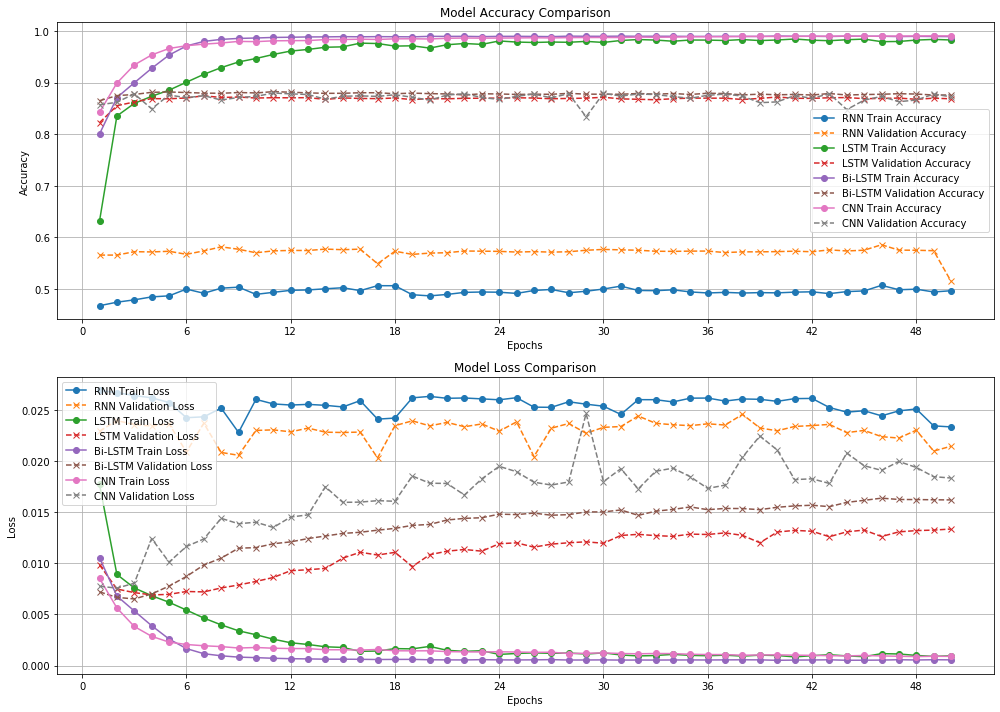

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Define the number of epochs (same for all models)
epochs = range(1, 51)  # Replace 51 with the actual number of epochs if different

# Plot Accuracy Comparison
plt.figure(figsize=(14, 10))

# Subplot for accuracy comparison
plt.subplot(2, 1, 1)
for model_name, metrics in model_results.items():
    plt.plot(epochs, metrics["train_accuracy"], label=f"{model_name} Train Accuracy", linestyle="-", marker="o")
    plt.plot(epochs, metrics["val_accuracy"], label=f"{model_name} Validation Accuracy", linestyle="--", marker="x")
plt.title("Model Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot for loss comparison
plt.subplot(2, 1, 2)
for model_name, metrics in model_results.items():
    plt.plot(epochs, metrics["train_loss"], label=f"{model_name} Train Loss", linestyle="-", marker="o")
    plt.plot(epochs, metrics["val_loss"], label=f"{model_name} Validation Loss", linestyle="--", marker="x")
plt.title("Model Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.grid(True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()
